# Módulos

In [1]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install spacy>=3.3.0

In [3]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 2.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [4]:
!pip install pyLDAvis==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=ad49ff280abf5a6f60ada422161e380a0e1390656072feb74dfc4617a8f00292
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=1dce464a473c11070c6031411518d491af9dfd2af00c66e13af2fbf4d54ad88c
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [5]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

import os
import glob
import zlib
import base64
import pickle
import tqdm

import wordcloud

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# Definições

In [6]:
stopwords_ = stopwords.words('portuguese')
stopwords_.extend(
    [ 
      'sr', 'sra', 'srs', 'sras', 'a', 'e', 'o', 'as', 'os', 'da', 'de', 'do', 'das', 'dos', 'à', 'às', 'um', 'uma', 'uns', 'umas', 'ao', 'aos', \
      'presidente', 'quero', 'obrigado', 'importante', 'importantes', 'momento', 'governo', 'nº', 'parabéns', 'parabenizar', 'casa', 'deputado', \
      'deputados', 'agradecer', 'senhor', 'senhora', 'senhores', 'senhoras', \
    ]
)

ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'

from google.colab import drive
drive.mount('/content/drive')

RANDOM_STATE = 12

Mounted at /content/drive


In [7]:
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

# Carregando discursos

In [8]:
discursos = pd.read_json(ROOTDIR + 'data/discursos_dataset.json')

# Criando bigramas e trigramas

In [9]:
if not os.path.isfile(ROOTDIR + f'data/bigramas.dat'):
  bigramas = gensim.models.Phrases(discursos.tokens, min_count=10, threshold=100)

  with open(ROOTDIR + f'data/bigramas.dat', 'wb') as fp:
    pickle.dump(bigramas, fp)

else:
  with open(ROOTDIR + f'data/bigramas.dat', 'rb') as fp:
    bigramas = pickle.load(fp)

In [10]:
if not os.path.isfile(ROOTDIR + f'data/trigramas.dat'):
  trigramas = gensim.models.Phrases(bigramas[discursos.tokens], min_count=10, threshold=100)

  with open(ROOTDIR + f'data/trigramas.dat', 'wb') as fp:
    pickle.dump(trigramas, fp)    

else:
  with open(ROOTDIR + f'data/trigramas.dat', 'rb') as fp:
    trigramas = pickle.load(fp)

In [11]:
if not os.path.isfile(ROOTDIR + f'data/bigrama_model.dat'):
  bigrama_model = gensim.models.phrases.Phraser(bigramas)

  with open(ROOTDIR + f'data/bigrama_model.dat', 'wb') as fp:
    pickle.dump(bigrama_model, fp)

else:
  with open(ROOTDIR + f'data/bigrama_model.dat', 'rb') as fp:
    bigrama_model = pickle.load(fp)

In [12]:
if not os.path.isfile(ROOTDIR + f'data/trigrama_model.dat'):
  trigrama_model = gensim.models.phrases.Phraser(trigramas)

  with open(ROOTDIR + f'data/trigrama_model.dat', 'wb') as fp:
    pickle.dump(trigrama_model, fp)

else:
  with open(ROOTDIR + f'data/trigrama_model.dat', 'rb') as fp:
    trigrama_model = pickle.load(fp)

# Limpeza do texto


In [13]:
nlp = spacy.load('pt_core_news_sm')


def clean_text(tokens):
  
  tokens = [tk for tk in tokens if len(tk) >= 2]
  tokens = [tk for tk in tokens if tk not in stopwords_]
  tokens = bigrama_model[tokens]
  tokens = trigrama_model[tokens]
  tokens = [(tk.text if tk.pos_ == 'NOUN' else tk.lemma_) for tk in nlp(" ".join(tokens)) if tk.pos_ in ('NOUN', 'VERB')] 

  return tokens


if not os.path.isfile(ROOTDIR + f'data/pos_tag_noun_verb_dataset.dat'):

  discursos['pos_tag'] = discursos.tokens.map(clean_text)

  with open(ROOTDIR + f'data/pos_tag_noun_verb_dataset.dat', 'wb') as fp:
    pickle.dump(discursos, fp)

else:
  with open(ROOTDIR + f'data/pos_tag_noun_verb_dataset.dat', 'rb') as fp:
    discursos = pickle.load(fp)

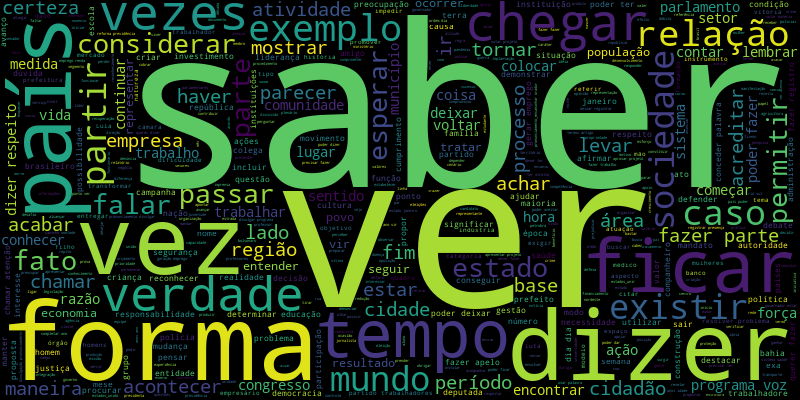

In [14]:
wordcloud.WordCloud(width=800, height=400, max_words=500).generate_from_text(' '.join(discursos.pos_tag.map(lambda ts: ' '.join(ts)))).to_image()

# Dicionário e Corpus

### Dicionário

In [15]:
id2word = corpora.Dictionary(discursos.pos_tag)
print('Palavras no dicionario:', len(id2word.token2id.keys()))
NO_BELOW=3
NO_ABOVE=0.05
id2word.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
print('Palavras no dicionario:', len(id2word.token2id.keys()))

Palavras no dicionario: 158186
Palavras no dicionario: 79134


### Remove os tokens mais frequentes

In [16]:
discursos['pos_tag'] = discursos.pos_tag.map(lambda ts: [t for t in ts if id2word.token2id.get(t, False)])

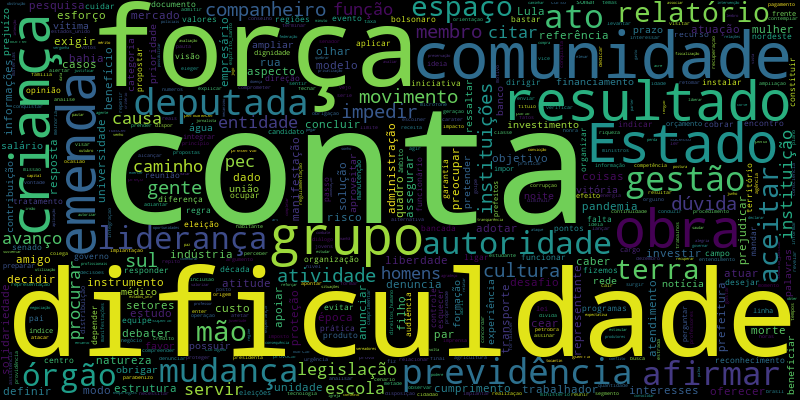

In [17]:
wordcloud.WordCloud(width=800, height=400, max_words=500).generate_from_text(' '.join(discursos.pos_tag.map(lambda ts: ' '.join(ts)))).to_image()

### Corpus

In [18]:
corpus = [id2word.doc2bow(d) for d in discursos.pos_tag.values]

# LDA

### Busca de hiperparâmetros

In [19]:
# K topicos
start_k = 2
end_k = 50
pace = 1
k_list = range(start_k, end_k+pace, pace)

k_list = [12]

print(len(k_list))

1


In [20]:
# Alpha
alpha = [0.01, 0.5, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

alpha = [1]

print(len(alpha))

1


In [21]:
# Beta
beta = [0.01, 0.5, 1]
beta.append('symmetric')

beta = [0.5]

print(len(beta))


1


In [22]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k, 
        random_state=RANDOM_STATE,        
        alpha=a,
        eta=b
    )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=discursos.pos_tag, dictionary=id2word, coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()

In [23]:
if not os.path.isfile(ROOTDIR + f'data/lda_model.dat'):

  history = {
      'k': [],
      'alpha': [],
      'beta': [],
      'coherence_score': [],
  }

  pbar = tqdm.tqdm(total=len(alpha)*len(beta)*len(k_list))

  last_cv = 0

  for k in k_list:
    for a in alpha:
      for b in beta:

        lda_model, cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k, a=a, b=b)

        if cv > last_cv:
          last_cv = cv
          
          with open(ROOTDIR + f'data/lda_model.dat', 'wb') as fp:
            pickle.dump(lda_model, fp)

        history['k'].append(k)
        history['alpha'].append(a)
        history['beta'].append(b)
        history['coherence_score'].append(cv)

        pbar.update(1)

  pbar.close()

  history = pd.DataFrame(history)
  history.to_json(ROOTDIR + f'data/history_lda_model.json')


else:

  with open(ROOTDIR + f'data/lda_model.dat', 'rb') as fp:
    lda_model = pickle.load(fp)

  history = pd.read_json(ROOTDIR + f'data/history_lda_model.json')


In [24]:
history

,k,alpha,beta,coherence_score
0,2,1.0,0.5,0.353441
1,2,1.0,1.0,0.353441
2,2,0.5,0.5,0.348317
3,2,0.5,1.0,0.348317
4,3,1.0,0.5,0.395099
5,3,1.0,1.0,0.395099
6,3,0.5,0.5,0.387487
7,3,0.5,1.0,0.389981


In [25]:
if len(k_list) > 1:
  plt.figure(figsize=(10,5))
  sns.lineplot(data=history, y='coherence_score', x='k')
  plt.xlabel("k")
  plt.ylabel("Coherence Score")
  plt.show()

if len(alpha) > 1: 
  plt.figure(figsize=(10,5))
  sns.lineplot(data=history, y='coherence_score', x='alpha')
  plt.xlabel("alpha")
  plt.ylabel("Coherence Score")
  plt.show()

if len(beta) > 1: 
  plt.figure(figsize=(10,5))
  sns.lineplot(data=history, y='coherence_score', x='beta')
  plt.xlabel("beta")
  plt.ylabel("Coherence Score")
  plt.show()

In [26]:
history.sort_values(by='coherence_score', ascending=False).iloc[0]

k                  3.000000
alpha              1.000000
beta               0.500000
coherence_score    0.395099
Name: 4, dtype: float64

### Visualizando distribuição e tópicos

In [27]:
with open(ROOTDIR + f'data/lda_model.dat', 'rb') as fp:
  best_lda_model = pickle.load(fp)

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, id2word, mds='mmds')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.119227  0.174772       1        1  18.834888
2      0.094475  0.288550       2        1  14.021037
6     -0.014887  0.247545       3        1  13.237656
3      0.244940  0.191094       4        1  10.570784
14    -0.133811  0.156281       5        1   9.911872
7     -0.212292  0.061672       6        1   8.799250
1      0.007066  0.035143       7        1   4.832449
4     -0.159720  0.285635       8        1   4.408338
10    -0.158582 -0.092557       9        1   3.059546
16    -0.146336 -0.230695      10        1   2.697714
11     0.038376 -0.157451      11        1   2.112651
15     0.171048 -0.081001      12        1   1.696182
0      0.284728 -0.026975      13        1   1.688682
8     -0.410557 -0.075471      14        1   1.588690
13    -0.011675 -0.268404      15        1   0.990633
9      0.191439 -0.228234      16        1   0.853573
12     0.096561 -0.279903      17        1   0.696054, topic_info=               Term          Freq         Total Category  logprob  loglift
385     previdência  17668.000000  17668.000000  Default  30.0000  30.0000
2267       crianças  10995.000000  10995.000000  Default  29.0000  29.0000
413    universidade  13814.000000  13814.000000  Default  28.0000  28.0000
2328    trabalhador  17553.000000  17553.000000  Default  27.0000  27.0000
1060           água  19517.000000  19517.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3487        tarifas    244.206663   1431.347319  Topic17  -5.8864   3.1991
3656         tarifa    201.085030    924.382653  Topic17  -6.0807   3.4421
14207       roraima    212.003007   2423.700582  Topic17  -6.0278   2.5310
2618   consumidores    170.822392    958.039231  Topic17  -6.2438   3.2432
2660        agência    173.766439   5548.400772  Topic17  -6.2267   1.5039

[1084 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5537      1  0.003042  Amazônia
5537      2  0.001521  Amazônia
5537      3  0.006083  Amazônia
5537      4  0.003042  Amazônia
5537      5  0.007604  Amazônia
...     ...       ...       ...
365      12  0.001461    órgãos
365      13  0.000091    órgãos
365      15  0.000183    órgãos
365      16  0.000091    órgãos
365      17  0.000091    órgãos

[16320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 4, 15, 8, 2, 5, 11, 17, 12, 16, 1, 9, 14, 10, 13])

## Inferir tópicos de determinado discurso

In [29]:
um_discurso = discursos.sample(1)
um_discurso_bow = id2word.doc2bow(
    um_discurso.pos_tag.values[0]
)

for topicid, pt in sorted(best_lda_model[um_discurso_bow], key=lambda i: i[1], reverse=True):
  print([id2word[wordid] for wordid, pw in best_lda_model.get_topic_terms(topicid)], f'{pt*100:.2f}%')

print("\n" + "\n".join([" ".join(ss) for ss in um_discurso.sentences.values[0]]))

['eleição', 'eleições', 'votos', 'candidato', 'eleger', 'financiamento', 'candidatos', 'eleitor', 'pmdb', 'reeleição'] 39.69%
['deputada', 'cumprimentar', 'mulher', 'cultura', 'homens', 'honra', 'comemorar', 'vereador', 'vice', 'amigo'] 34.27%
['pec', 'art', 'obstrução', 'emendas', 'emenda', 'urgência', 'pauta', 'reunião', 'relatório', 'bancada'] 20.16%

sr presidente quero cumprimentá lo e agradecê lo pela oportunidade
cumprimento também todos os prefeitos de minas gerais que estão aqui demostrando o seu compromisso e amor à vida
palmas nas galerias
minas gerais sempre está dando exemplo ao brasil
quero aqui lembrar quando o presidente da assembleia à época dinis pinheiro junto com todos os prefeitos de minas gerais trouxe aqui milhões de assinaturas para alertar o brasil da importância de se ter mais recursos para a saúde
e hoje continuam essa luta
os prefeitos lutam por mais recursos para a saúde
portanto presidente fabinho muito obrigado
parabéns aos prefeitos mineiros
palmas nas g